## Applying Black-Scholes formula European calls and puts option prices for Spotify Technology S.A. (SPOT)


## Importing Libraries

In [2]:
from math import sqrt, log, pow, erf, e
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm

## Collecting Spotify Technology S.A. (SPOT) Data from Yahoo Finace

In [3]:
# Define the stock ticker and date for SPOT
spot_ticker = 'SPOT'
spot_option = yf.Ticker(spot_ticker)
spot_option.options

('2024-08-09',
 '2024-08-16',
 '2024-08-23',
 '2024-08-30',
 '2024-09-06',
 '2024-09-20',
 '2024-10-18',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

In [4]:
# Selecting an expiration date
spot_date = '2024-12-20'

# Function to fetch options data for SPOT
def fetch_spot_options_data(ticker_symbol, date):
    ticker = yf.Ticker(ticker_symbol)
    options_data = ticker.option_chain(date)
    return options_data.calls, options_data.puts

# Fetch calls and puts data for SPOT
spot_calls, spot_puts = fetch_spot_options_data(spot_ticker, spot_date)

# Convert calls data to a DataFrame and display the first few rows
spot_calls_df = pd.DataFrame(spot_calls)
spot_calls_df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPOT241220C00110000,2024-06-06 15:01:57+00:00,110.0,216.54,205.35,213.45,0.0,0.0,NaN,7,0.00001,True,REGULAR,USD
1,SPOT241220C00115000,2024-03-28 17:40:16+00:00,115.0,157.09,174.90,181.95,0.0,0.0,1.0,1,0.00001,True,REGULAR,USD
2,SPOT241220C00120000,2024-06-17 19:57:50+00:00,120.0,196.33,173.50,182.15,0.0,0.0,1.0,3,0.00001,True,REGULAR,USD
3,SPOT241220C00125000,2024-04-15 19:45:40+00:00,125.0,172.48,178.20,186.10,0.0,0.0,NaN,1,0.00001,True,REGULAR,USD
4,SPOT241220C00150000,2024-02-06 14:36:51+00:00,150.0,107.20,124.50,131.60,0.0,0.0,NaN,1,0.00001,True,REGULAR,USD


In [5]:
# Convert puts data to a DataFrame and display the first few rows
spot_puts_df = pd.DataFrame(spot_puts)
spot_puts_df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPOT241220P00105000,2024-07-18 14:13:32+00:00,105.0,0.30,0.00,0.40,0.0,0.0,1,1,0.756838,False,REGULAR,USD
1,SPOT241220P00110000,2024-06-20 18:03:32+00:00,110.0,0.37,0.00,0.65,0.0,0.0,1,5,0.772463,False,REGULAR,USD
2,SPOT241220P00120000,2024-07-09 17:46:08+00:00,120.0,0.25,0.00,1.76,0.0,0.0,5,20,0.825441,False,REGULAR,USD
3,SPOT241220P00125000,2024-06-18 13:30:56+00:00,125.0,0.30,0.13,0.61,0.0,0.0,1,2,0.699710,False,REGULAR,USD
4,SPOT241220P00130000,2024-06-18 13:30:56+00:00,130.0,0.37,0.17,0.65,0.0,0.0,1,7,0.682620,False,REGULAR,USD


## Exploring SPOT

In [6]:
spot_calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     39 non-null     object             
 1   lastTradeDate      39 non-null     datetime64[ns, UTC]
 2   strike             39 non-null     float64            
 3   lastPrice          39 non-null     float64            
 4   bid                39 non-null     float64            
 5   ask                39 non-null     float64            
 6   change             39 non-null     float64            
 7   percentChange      39 non-null     float64            
 8   volume             36 non-null     float64            
 9   openInterest       39 non-null     int64              
 10  impliedVolatility  39 non-null     float64            
 11  inTheMoney         39 non-null     bool               
 12  contractSize       39 non-null     object           

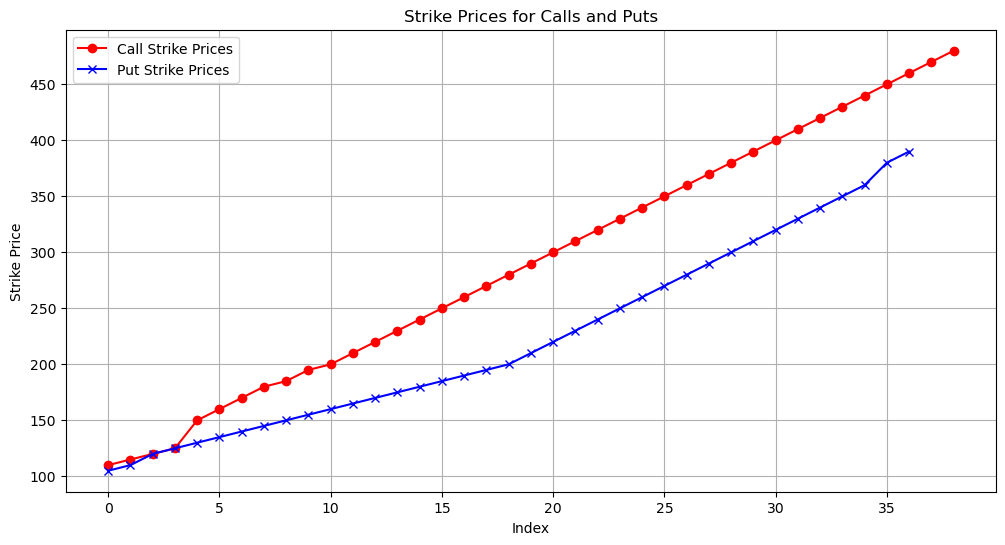

In [56]:
import matplotlib.pyplot as plt

# Ensure both calls_df and puts_df have 'strike' columns
if 'strike' in calls_df.columns and 'strike' in puts_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot strike prices for calls
    plt.plot(calls_df['strike'], label='Call Strike Prices', marker='o', linestyle='-', color='r')
    
    # Plot strike prices for puts
    plt.plot(puts_df['strike'], label='Put Strike Prices', marker='x', linestyle='-', color='b')
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Strike Price')
    plt.title('Strike Prices for Calls and Puts')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("The required columns are not present in the DataFrames.")


## Computing other parameters including S,t, r, and vol (σ)

In [9]:
import yfinance as yf

def get_current_stock_price(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    return current_price

# Example usage for SPOT
S= get_current_stock_price(spot_ticker)
print(f"Current Stock Price for SPOT: ${S:.2f}")


Current Stock Price for SPOT: $330.85


In [10]:
def get_10yr_euro_gov_bond_yield():
    # SPDR Bloomberg Euro Government Bond
    euro_bond_ticker = "SYBB.DE"
    now = datetime.now()
    ten_years_ago = now.replace(year=now.year - 10)
    bond_data = yf.download(euro_bond_ticker, start=ten_years_ago, end=now)
    
    # Check if data is available
    if not bond_data.empty:
        last_yield = bond_data['Close'].iloc[-1]
        return last_yield
    else:
        return "No data available"

# Example usage
r = get_10yr_euro_gov_bond_yield()/100
if isinstance(r, str):
    print(f"10-Year Euro Government Bond Yield: {r}")
else:
    print(f"10-Year Euro Government Bond Yield: {r:.2f}")


[*********************100%%**********************]  1 of 1 completed

10-Year Euro Government Bond Yield: 0.57


In [11]:
from datetime import datetime

def get_time_to_maturity(date_str):
    # Assuming the date string is in the format 'YYYY-MM-DD'
    date_object = datetime.strptime(date_str, '%Y-%m-%d')

    current_date = datetime.now()
    years_difference = (date_object - current_date).days / 365.25
    return years_difference

# Example usage
t = get_time_to_maturity(spot_date)
print(f"Time to Maturity for SPOT: {t:.2f} years")


Time to Maturity for SPOT: 0.38 years


In [12]:
import yfinance as yf
import numpy as np

def calculate_volatility(ticker_symbol, period='1y'):
    # Fetch historical data
    stock = yf.Ticker(ticker_symbol)
    data = stock.history(period=period)
    
    # Calculate daily returns
    data['Daily Return'] = data['Close'].pct_change()
    
    # Calculate the standard deviation of daily returns (volatility)
    volatility = np.std(data['Daily Return'].dropna()) * np.sqrt(252)  # Annualize the volatility
    return volatility


vol = calculate_volatility(spot_ticker)
print(f"Annualized Volatility for {spot_ticker}: {vol:.2%}")


Annualized Volatility for SPOT: 37.06%


## Defining parameters of the BSM formula

In [13]:
def standard_normal_cdf(x):
    return 0.5 * (1 + erf(x / sqrt(2)))


In [14]:
def d1(S, K, t, r, vol):
    numerator = log(S/K) + (r + pow(vol, 2)/2) * t
    denominator = vol * sqrt(t)
    return numerator / denominator


In [15]:
def d2(S, K, t, r, vol):
    return d1(S, K, t, r, vol) - vol * sqrt(t)


In [16]:
def call_price(S, K, t, r, vol):
    Nd1 = standard_normal_cdf(d1(S, K, t, r, vol))
    Nd2 = standard_normal_cdf(d2(S, K, t, r, vol))
    return Nd1 * S - Nd2 * K * pow(e, -1 * r * t)


In [17]:
def put_price(S, K, t, r, vol):
    Nd1 = standard_normal_cdf(- 1 * d1(S, K, t, r, vol))
    Nd2 = standard_normal_cdf(- 1 * d2(S, K, t, r, vol))
    return Nd2 * K * pow(e, -1 * r * t) - S * Nd1


In [33]:
columns_to_drop = ['lastTradeDate', 'lastPrice', 'volume', 'openInterest', 'contractSize', 'currency','change', 'percentChange', 'impliedVolatility', 'inTheMoney']

In [ ]:
## Computing Calls and Puts

In [61]:
# Drop the unnecessary columns from both DataFrames
spot_calls_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
# Compute call and put prices
spot_calls_df['bsfCallPrice'] = spot_calls_df.apply(lambda row: call_price(S, row['strike'], t, r, vol), axis=1)

In [62]:

# Create DataFrames with desired columns
calls_df = spot_calls_df[['contractSymbol', 'strike', 'bid', 'ask']].copy()
calls_df['Intial Price'] = S
calls_df['Maturity time'] = t
calls_df['Risk-free interest'] = r
calls_df['Volatility'] = vol
calls_df['BSF Calls Price'] = spot_calls_df['bsfCallPrice']


# Display the updated DataFrames
print("Calls DataFrame with desired columns:")
calls_df.head(10)



Calls DataFrame with desired columns:


,contractSymbol,strike,bid,ask,Intial Price,Maturity time,Risk-free interest,Volatility,BSF Calls Price
0,SPOT241220C00110000,110.0,205.35,213.45,330.850006,0.377823,0.568,0.370625,242.095281
1,SPOT241220C00115000,115.0,174.90,181.95,330.850006,0.377823,0.568,0.370625,238.060975
2,SPOT241220C00120000,120.0,173.50,182.15,330.850006,0.377823,0.568,0.370625,234.026669
3,SPOT241220C00125000,125.0,178.20,186.10,330.850006,0.377823,0.568,0.370625,229.992364
4,SPOT241220C00150000,150.0,124.50,131.60,330.850006,0.377823,0.568,0.370625,209.820883
5,SPOT241220C00160000,160.0,110.10,116.75,330.850006,0.377823,0.568,0.370625,201.752409
6,SPOT241220C00170000,170.0,125.30,130.75,330.850006,0.377823,0.568,0.370625,193.684234
7,SPOT241220C00180000,180.0,133.15,139.55,330.850006,0.377823,0.568,0.370625,185.616835
8,SPOT241220C00185000,185.0,113.45,119.70,330.850006,0.377823,0.568,0.370625,181.583713
9,SPOT241220C00195000,195.0,142.20,151.10,330.850006,0.377823,0.568,0.370625,173.519660


In [63]:
# Descriptive statistics for Calls
calls_descriptive_stats = calls_df[['strike', 'bid', 'ask', 'Intial Price', 'Maturity time', 'Risk-free interest', 'Volatility', 'BSF Calls Price']].describe()

# Display the descriptive statistics for Calls
print("Descriptive Statistics for Calls:")
calls_descriptive_stats


Descriptive Statistics for Calls:


,strike,bid,ask,Intial Price,Maturity time,Risk-free interest,Volatility,BSF Calls Price
count,39.000000,39.000000,39.000000,39.000000,3.900000e+01,39.000,3.900000e+01,39.000000
mean,291.538462,72.585641,76.397436,330.850006,3.778234e-01,0.568,3.706255e-01,108.905916
std,112.109872,58.864589,61.183796,0.000000,2.811841e-16,0.000,3.374209e-16,74.489404
min,110.000000,0.340000,4.450000,330.850006,3.778234e-01,0.568,3.706255e-01,11.778530
25%,197.500000,16.950000,19.125000,330.850006,3.778234e-01,0.568,3.706255e-01,40.338271
50%,290.000000,62.050000,64.750000,330.850006,3.778234e-01,0.568,3.706255e-01,98.624534
75%,385.000000,114.575000,120.500000,330.850006,3.778234e-01,0.568,3.706255e-01,171.504517
max,480.000000,205.350000,213.450000,330.850006,3.778234e-01,0.568,3.706255e-01,242.095281


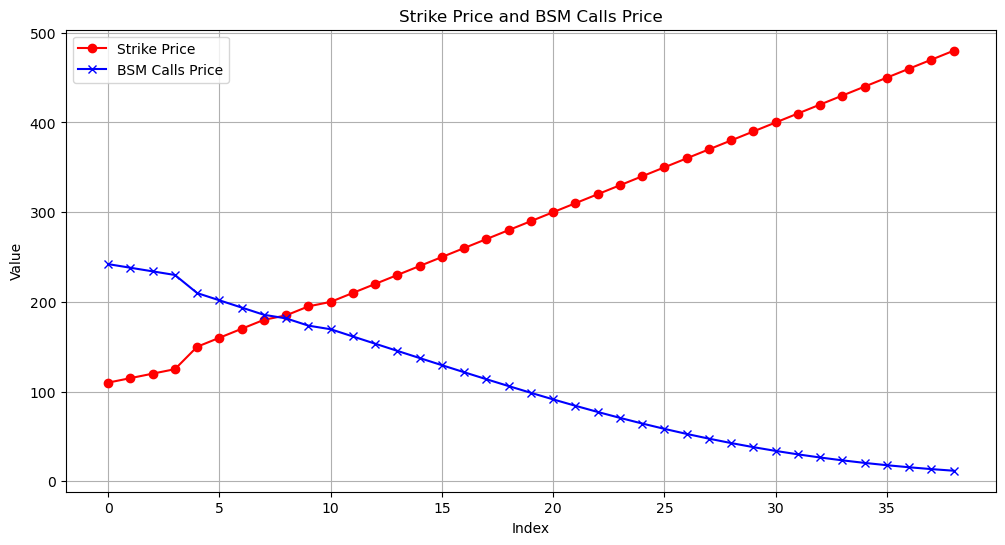

In [51]:
import matplotlib.pyplot as plt

# Ensure calls_df has 'strike' and 'BSM Calls Price' columns
if 'strike' in calls_df.columns and 'BSM Calls Price' in calls_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot 'strike' price
    plt.plot(calls_df.index, calls_df['strike'], marker='o', linestyle='-', color='r', label='Strike Price')
    
    # Plot 'BSM Calls Price'
    plt.plot(calls_df.index, calls_df['BSM Calls Price'], marker='x', linestyle='-', color='b', label='BSM Calls Price')
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Strike Price and BSM Calls Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("The required columns are not present in the DataFrame.")


In [ ]:
spot_puts_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
spot_puts_df['bsfPutPrice'] = spot_puts_df.apply(lambda row: put_price(S, row['strike'], t, r, vol), axis=1)

In [54]:
puts_df = spot_puts_df[['contractSymbol', 'strike', 'bid', 'ask']].copy()
puts_df['Intial Price'] = S
puts_df['Maturity time'] = t
puts_df['Risk-free interest'] = r
puts_df['Volatility'] = vol
puts_df['BSM Puts Price'] = spot_puts_df['bsmPutPrice']

print("\nPuts DataFrame with desired columns:")
puts_df.head(10)



Puts DataFrame with desired columns:


,contractSymbol,strike,bid,ask,Intial Price,Maturity time,Risk-free interest,Volatility,BSM Puts Price
0,SPOT241220P00105000,105.0,0.00,0.40,330.850006,0.377823,0.568,0.370625,6.725891e-09
1,SPOT241220P00110000,110.0,0.00,0.65,330.850006,0.377823,0.568,0.370625,2.438388e-08
2,SPOT241220P00120000,120.0,0.00,1.76,330.850006,0.377823,0.568,0.370625,2.438235e-07
3,SPOT241220P00125000,125.0,0.13,0.61,330.850006,0.377823,0.568,0.370625,6.847462e-07
4,SPOT241220P00130000,130.0,0.17,0.65,330.850006,0.377823,0.568,0.370625,1.794720e-06
5,SPOT241220P00135000,135.0,0.09,1.03,330.850006,0.377823,0.568,0.370625,4.418110e-06
6,SPOT241220P00140000,140.0,1.95,3.30,330.850006,0.377823,0.568,0.370625,1.027243e-05
7,SPOT241220P00145000,145.0,0.30,1.43,330.850006,0.377823,0.568,0.370625,2.266970e-05
8,SPOT241220P00150000,150.0,0.16,1.06,330.850006,0.377823,0.568,0.370625,4.769256e-05
9,SPOT241220P00155000,155.0,0.19,1.04,330.850006,0.377823,0.568,0.370625,9.602297e-05


In [59]:
# Descriptive statistics for Puts
puts_descriptive_stats = puts_df[['strike', 'bid', 'ask', 'Intial Price', 'Maturity time', 'Risk-free interest', 'Volatility', 'BSM Puts Price']].describe()

# Display the descriptive statistics for Puts
print("Descriptive Statistics for Puts:")
puts_descriptive_stats


Descriptive Statistics for Puts:


,strike,bid,ask,Intial Price,Maturity time,Risk-free interest,Volatility,BSM Puts Price
count,37.000000,37.000000,37.000000,37.000000,3.700000e+01,37.000,3.700000e+01,3.700000e+01
mean,223.378378,12.184865,13.237027,330.850006,3.778234e-01,0.568,3.706255e-01,2.494817e+00
std,83.732826,18.473962,18.669169,0.000000,2.251074e-16,0.000,3.376612e-16,5.234215e+00
min,105.000000,0.000000,0.400000,330.850006,3.778234e-01,0.568,3.706255e-01,6.725891e-09
25%,155.000000,0.300000,1.500000,330.850006,3.778234e-01,0.568,3.706255e-01,9.602297e-05
50%,200.000000,2.640000,3.400000,330.850006,3.778234e-01,0.568,3.706255e-01,1.159569e-02
75%,290.000000,15.100000,18.350000,330.850006,3.778234e-01,0.568,3.706255e-01,1.764258e+00
max,390.000000,69.150000,70.200000,330.850006,3.778234e-01,0.568,3.706255e-01,2.188612e+01


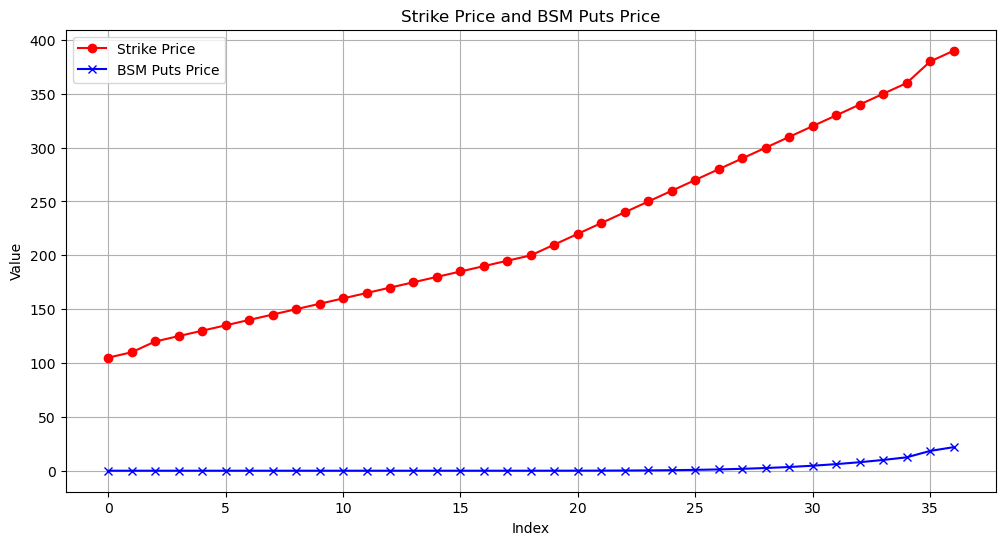

In [55]:
import matplotlib.pyplot as plt

# Ensure puts_df has 'strike' and 'BSM Puts Price' columns
if 'strike' in puts_df.columns and 'BSM Puts Price' in puts_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot 'strike' price
    plt.plot(puts_df.index, puts_df['strike'], marker='o', linestyle='-', color='r', label='Strike Price')
    
    # Plot 'BSM Puts Price'
    plt.plot(puts_df.index, puts_df['BSM Puts Price'], marker='x', linestyle='-', color='b', label='BSM Puts Price')
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Strike Price and BSM Puts Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("The required columns are not present in the DataFrame.")
